In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data
from nn_modules import View


In [2]:
torch.__version__

'0.4.1'

In [3]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=False)
train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [4]:
len(train_input)

1000

5


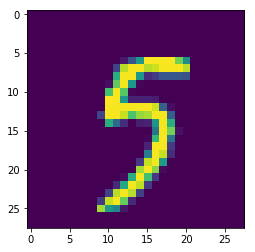

In [5]:
i = 420
plt.imshow(train_input[i, 0, :, :])
print(train_target[i].item())

## 1) LeNet with disjoint trainset and testset

In [6]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

in_channels = train_input.shape[1]
out_channels = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size = 3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size = 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
LeNet_gen = lambda : Net()

In [ ]:
#debug_layers_dims(LeNet_gen(), train_input.shape)

In [ ]:
target_classes = np.array(train_target.tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

In [ ]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

LeNet = LeNet_gen()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.05

mt = ModelTrainer(LeNet, loss_fun, optim.SGD(LeNet.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=100, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Testing with a fraction of data from trainset (10%)

In [ ]:
test_input.shape

In [ ]:
def generate_biasedset(train_dataset, test_dataset, bias=0.2, plot=False):
    train_input = train_dataset[0]
    train_target = train_dataset[1]
    test_input = test_dataset[0]
    test_target = test_dataset[1]
    
    biased_input = test_input.clone()
    biased_target = test_target.clone()

    N = len(train_input)
    indices_add = np.random.choice(np.arange(0, N), int(bias * N))

    M = len(test_input)
    indices_replace = np.random.choice(np.arange(0, M), int(bias * M))

    for i in range(len(indices_add)):
        biased_input[indices_replace[i]] = train_input[indices_add[i]]
        biased_target[indices_replace[i]] = train_target[indices_add[i]]
        
    if plot:
        plt.subplot(121)
        plt.imshow(biased_input[indices_replace[0]][0])
        plt.subplot(122)
        plt.imshow(test_input[indices_replace[0]][0])

    return (biased_input, biased_target)

In [ ]:
biased_dataset = generate_biasedset(train_dataset, test_dataset, plot=True)

In [ ]:
target_classes = np.array(biased_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

In [ ]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

LeNet = LeNet_gen()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(LeNet, loss_fun, optim.SGD(LeNet.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, biased_dataset, epochs=40, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

In [ ]:
test_input.shape

In [ ]:
def generate_biasedset(train_dataset, test_dataset, bias=0.2, plot=False):
    train_input = train_dataset[0]
    train_target = train_dataset[1]
    test_input = test_dataset[0]
    test_target = test_dataset[1]
    
    biased_input = test_input.clone()
    biased_target = test_target.clone()

    N = len(train_input)
    indices_add = np.random.choice(np.arange(0, N), int(bias * N))

    M = len(test_input)
    indices_replace = np.random.choice(np.arange(0, M), int(bias * M))

    for i in range(len(indices_add)):
        biased_input[indices_replace[i]] = train_input[indices_add[i]]
        biased_target[indices_replace[i]] = train_target[indices_add[i]]
        
    if plot:
        plt.subplot(121)
        plt.imshow(biased_input[indices_replace[0]][0])
        plt.subplot(122)
        plt.imshow(test_input[indices_replace[0]][0])

    return (biased_input, biased_target)

In [ ]:
biased_dataset = generate_biasedset(train_dataset, test_dataset, plot=True)

In [ ]:
target_classes = np.array(biased_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

In [ ]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

LeNet = LeNet_gen()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(LeNet, loss_fun, optim.SGD(LeNet.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, biased_dataset, epochs=40, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 3) Hooks definition to get layers activations

In [ ]:
activation_output = dict()

In [ ]:
def spyOn(model, dict_, name):
    def hook_fun (m, input_, output_): 
        dict_[name] = output_
        print("captured output at layer : "+str(m)) 
            
    handle = model.register_forward_hook(hook_fun)
    return handle

In [ ]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
handle = spyOn(LeNet.conv2, activation_output, 'convolution 2')

In [ ]:
LeNet.eval()
LeNet(train_input[0].reshape(-1, 1, 28, 28))

In [ ]:
activation_output['convolution 2'].flatten()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(alexnet.parameters(), lr=0.001)

In [ ]:
target.reshape(-1, 1)

In [ ]:
crit_fun = lambda input_, target : (input_, target.reshape(-1, 1))
y_hat_fun = lambda y: y.max(1)

mt = ModelTrainer(alexnet32, criterion, optimizer, y_hat_fun, crit_fun)
hist = mt.fit((train_input, train_target), (test_input, test_target), epochs=500, batch_size=250, verbose=10)
mt.plot_training("Learning curves")